In [498]:
import sys
import os
import numpy as np
import numpy.fft as fourier
import math

from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.transpose(img0))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.transpose(img1))
    sub1.set_title(title1)


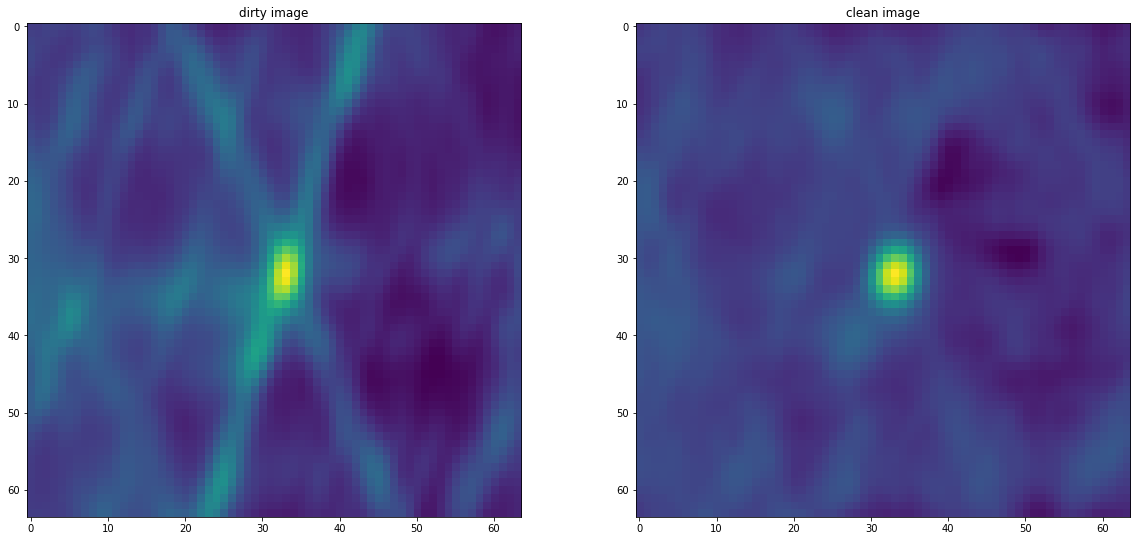

In [483]:
folder = "./img-csv/64x64pixels/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',')
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',')
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',')
model_map = np.genfromtxt(folder+'model.csv', delimiter=',')

plot_comparison(dirty_map, 'dirty image', clean_map, 'clean image')

***

## Dirty Map Reconstruction with gurobi

$minimize \left \| D_b - x \right \|_2^2$

In [540]:
dirty_flat = dirty_map.flatten()
m = Model("dirty-reconstruction")

x0 = []
for i in range(0, dirty_flat.size):
    x0.append(m.addVar(lb=-GRB.INFINITY))
    
obj = QuadExpr()
for i in range(0, dirty_flat.size):
    obj += (x0[i] - dirty_flat[i])*(x0[i] - dirty_flat[i])

m.setObjective(obj, GRB.MINIMIZE)
m.optimize()  

reconstruction = np.reshape([var.x for var in m.getVars()], dirty_map.shape)
del m
del obj

Optimize a model with 0 rows, 4096 columns and 0 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e-03, 6e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 4096 columns
Presolve time: 0.04s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.04 seconds
Optimal objective 1.33383082e-09


In [ ]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "reconstruction")

***
## Reconstruction with PSF ~ CLEAN

$minimize \left \| D_b - x * PSF \right \|_2^2$

In [458]:
D_FT = fourier.fft2(dirty_map)
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

PSF_FT = fourier.fft2(psf_map)
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

In [459]:
model = Model("dirty-psf")

x0_real = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
x0_imag = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)

objective = QuadExpr()
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        objective += (D_real[i, j] - x0_real[i, j] * PSF_real[i, j]) * (D_real[i, j] - x0_real[i, j] * PSF_real[i, j]) #real part
        objective += (D_imag[i, j] - x0_imag[i, j] * PSF_imag[i, j]) * (D_imag[i, j] - x0_imag[i, j] * PSF_imag[i, j]) #imaginary part

model.setObjective(objective, GRB.MINIMIZE)
model.optimize() 

FT_rec = np.zeros(dirty_map.shape, dtype=np.complex128)
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        FT_rec[i, j] = x0_real[i, j].x + x0_imag[i, j].x * 1j

reconstruction = fourier.ifft2(FT_rec).real
#reconst = np.roll(reconst, int(+54/2-1), axis=0)
#reconst = np.roll(reconst, int(+54/2-1), axis=1)

#rec2 = np.multiply(FT_rec.real, PSF_FT.real)
#reconstruction = fourier.ifft2(rec2).real

del model
del objective

Optimize a model with 0 rows, 8192 columns and 0 nonzeros
Model has 8188 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [8e-07, 9e+05]
  QObjective range [7e-11, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 0 rows and 8192 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds
Optimal objective 2.84984708e-07


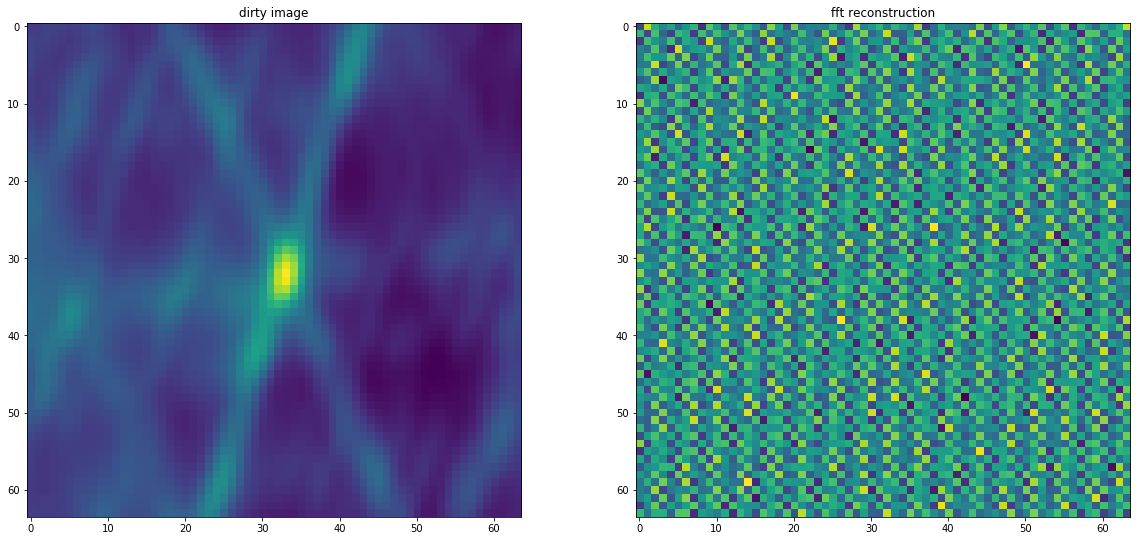

In [460]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "fft reconstruction")
np.savetxt("roll.csv",reconstruction, delimiter=',')

## Reconstruction with PSF ~ CLEAN

$minimize \left \| D_b - x * PSF \right \|_2^2 with x > 0$

In [ ]:
model = Model("dirty-second try")
model.Params.method = 0 #GRB Primal Simplex 

pixel = model.addVars(dirty_map.shape[0], dirty_map.shape[1])
psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)        
XC = int(-psf_map.shape[0]/2 -1)
YC = int(-psf_map.shape[1]/2 -1)
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        convolution = LinExpr()
        for xP in range(0, psf_map.shape[0]):
            for yP in range(0, psf_map.shape[1]):
                if x+XC+xP >= 0 and x+XC+xP < dirty_map.shape[0] and y+YC+yP >= 0 and y+YC+yP < dirty_map.shape[1]:
                    convolution += pixel[x+XC+xP, y+YC+yP] * psf_map[xP, yP]
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")

In [539]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

reconst_dirty02 = []
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        reconst_dirty02.append(pixel[x,y].x)
reconst_dirty02 = np.reshape(reconst_dirty02, dirty_map.shape)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Optimize a model with 4096 rows, 8192 columns and 9428996 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 3e+01]
Presolve time: 4.07s
Presolved: 4096 rows, 8192 columns, 9428996 nonzeros
Presolved model has 4096 quadratic objective terms

       0    9.5208415e+04   0.000000e+00   2.878823e+05      7s
      68    5.9772845e+04   0.000000e+00   0.000000e+00     10s

Solved in 68 iterations and 9.59 seconds
Optimal objective  5.977284488e+04


## Haar regularizer

In [545]:
D_FT = fourier.fft2(dirty_map)
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

PSF_FT = fourier.fft2(psf_map)
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

dimensions = dirty_map.shape[0]* dirty_map.shape[1]

In [556]:
haar = np.zeros((dimensions,dimensions))
p = 0
q = 0
p_val = 1
for k in range(0,dimensions):
    print(k, p_val)
    for j in range(0, dimensions):
        t = j/float(dimensions)
        if (q-1)/p_val <= t and t < (q-0.5)/p_val:
            haar[k, j] = 2^(int(p/2))
        elif (q-0.5)/p_val <= t and t < q/p_val:
            haar[k, j] = -2^(int(p/2))
        else:
            haar[k, j] = 0
    q += 1
    if p_val == q-1:
        q = 1
        p += 1
        p_val = 2**p
    

0 1
1 1
2 2
3 2
4 4
5 4
6 4
7 4
8 8
9 8
10 8
11 8
12 8
13 8
14 8
15 8
16 16
17 16
18 16
19 16
20 16
21 16
22 16
23 16
24 16
25 16
26 16
27 16
28 16
29 16
30 16
31 16
32 32
33 32
34 32
35 32
36 32
37 32
38 32
39 32
40 32
41 32
42 32
43 32
44 32
45 32
46 32
47 32
48 32
49 32
50 32
51 32
52 32
53 32
54 32
55 32
56 32
57 32
58 32
59 32
60 32
61 32
62 32
63 32
64 64
65 64
66 64
67 64
68 64
69 64
70 64
71 64
72 64
73 64
74 64
75 64
76 64
77 64
78 64
79 64
80 64
81 64
82 64
83 64
84 64
85 64
86 64
87 64
88 64
89 64
90 64
91 64
92 64
93 64
94 64
95 64
96 64
97 64
98 64
99 64
100 64
101 64
102 64
103 64
104 64
105 64
106 64
107 64
108 64
109 64
110 64
111 64
112 64
113 64
114 64
115 64
116 64
117 64
118 64
119 64
120 64
121 64
122 64
123 64
124 64
125 64
126 64
127 64
128 128
129 128
130 128
131 128
132 128
133 128
134 128
135 128
136 128
137 128
138 128
139 128
140 128
141 128
142 128
143 128
144 128
145 128
146 128
147 128
148 128
149 128
150 128
151 128
152 128
153 128
154 128
155 128
156 12

1091 1024
1092 1024
1093 1024
1094 1024
1095 1024
1096 1024
1097 1024
1098 1024
1099 1024
1100 1024
1101 1024
1102 1024
1103 1024
1104 1024
1105 1024
1106 1024
1107 1024
1108 1024
1109 1024
1110 1024
1111 1024
1112 1024
1113 1024
1114 1024
1115 1024
1116 1024
1117 1024
1118 1024
1119 1024
1120 1024
1121 1024
1122 1024
1123 1024
1124 1024
1125 1024
1126 1024
1127 1024
1128 1024
1129 1024
1130 1024
1131 1024
1132 1024
1133 1024
1134 1024
1135 1024
1136 1024
1137 1024
1138 1024
1139 1024
1140 1024
1141 1024
1142 1024
1143 1024
1144 1024
1145 1024
1146 1024
1147 1024
1148 1024
1149 1024
1150 1024
1151 1024
1152 1024
1153 1024
1154 1024
1155 1024
1156 1024
1157 1024
1158 1024
1159 1024
1160 1024
1161 1024
1162 1024
1163 1024
1164 1024
1165 1024
1166 1024
1167 1024
1168 1024
1169 1024
1170 1024
1171 1024
1172 1024
1173 1024
1174 1024
1175 1024
1176 1024
1177 1024
1178 1024
1179 1024
1180 1024
1181 1024
1182 1024
1183 1024
1184 1024
1185 1024
1186 1024
1187 1024
1188 1024
1189 1024
1190 1024


1910 1024
1911 1024
1912 1024
1913 1024
1914 1024
1915 1024
1916 1024
1917 1024
1918 1024
1919 1024
1920 1024
1921 1024
1922 1024
1923 1024
1924 1024
1925 1024
1926 1024
1927 1024
1928 1024
1929 1024
1930 1024
1931 1024
1932 1024
1933 1024
1934 1024
1935 1024
1936 1024
1937 1024
1938 1024
1939 1024
1940 1024
1941 1024
1942 1024
1943 1024
1944 1024
1945 1024
1946 1024
1947 1024
1948 1024
1949 1024
1950 1024
1951 1024
1952 1024
1953 1024
1954 1024
1955 1024
1956 1024
1957 1024
1958 1024
1959 1024
1960 1024
1961 1024
1962 1024
1963 1024
1964 1024
1965 1024
1966 1024
1967 1024
1968 1024
1969 1024
1970 1024
1971 1024
1972 1024
1973 1024
1974 1024
1975 1024
1976 1024
1977 1024
1978 1024
1979 1024
1980 1024
1981 1024
1982 1024
1983 1024
1984 1024
1985 1024
1986 1024
1987 1024
1988 1024
1989 1024
1990 1024
1991 1024
1992 1024
1993 1024
1994 1024
1995 1024
1996 1024
1997 1024
1998 1024
1999 1024
2000 1024
2001 1024
2002 1024
2003 1024
2004 1024
2005 1024
2006 1024
2007 1024
2008 1024
2009 1024


2748 2048
2749 2048
2750 2048
2751 2048
2752 2048
2753 2048
2754 2048
2755 2048
2756 2048
2757 2048
2758 2048
2759 2048
2760 2048
2761 2048
2762 2048
2763 2048
2764 2048
2765 2048
2766 2048
2767 2048
2768 2048
2769 2048
2770 2048
2771 2048
2772 2048
2773 2048
2774 2048
2775 2048
2776 2048
2777 2048
2778 2048
2779 2048
2780 2048
2781 2048
2782 2048
2783 2048
2784 2048
2785 2048
2786 2048
2787 2048
2788 2048
2789 2048
2790 2048
2791 2048
2792 2048
2793 2048
2794 2048
2795 2048
2796 2048
2797 2048
2798 2048
2799 2048
2800 2048
2801 2048
2802 2048
2803 2048
2804 2048
2805 2048
2806 2048
2807 2048
2808 2048
2809 2048
2810 2048
2811 2048
2812 2048
2813 2048
2814 2048
2815 2048
2816 2048
2817 2048
2818 2048
2819 2048
2820 2048
2821 2048
2822 2048
2823 2048
2824 2048
2825 2048
2826 2048
2827 2048
2828 2048
2829 2048
2830 2048
2831 2048
2832 2048
2833 2048
2834 2048
2835 2048
2836 2048
2837 2048
2838 2048
2839 2048
2840 2048
2841 2048
2842 2048
2843 2048
2844 2048
2845 2048
2846 2048
2847 2048


3595 2048
3596 2048
3597 2048
3598 2048
3599 2048
3600 2048
3601 2048
3602 2048
3603 2048
3604 2048
3605 2048
3606 2048
3607 2048
3608 2048
3609 2048
3610 2048
3611 2048
3612 2048
3613 2048
3614 2048
3615 2048
3616 2048
3617 2048
3618 2048
3619 2048
3620 2048
3621 2048
3622 2048
3623 2048
3624 2048
3625 2048
3626 2048
3627 2048
3628 2048
3629 2048
3630 2048
3631 2048
3632 2048
3633 2048
3634 2048
3635 2048
3636 2048
3637 2048
3638 2048
3639 2048
3640 2048
3641 2048
3642 2048
3643 2048
3644 2048
3645 2048
3646 2048
3647 2048
3648 2048
3649 2048
3650 2048
3651 2048
3652 2048
3653 2048
3654 2048
3655 2048
3656 2048
3657 2048
3658 2048
3659 2048
3660 2048
3661 2048
3662 2048
3663 2048
3664 2048
3665 2048
3666 2048
3667 2048
3668 2048
3669 2048
3670 2048
3671 2048
3672 2048
3673 2048
3674 2048
3675 2048
3676 2048
3677 2048
3678 2048
3679 2048
3680 2048
3681 2048
3682 2048
3683 2048
3684 2048
3685 2048
3686 2048
3687 2048
3688 2048
3689 2048
3690 2048
3691 2048
3692 2048
3693 2048
3694 2048


In [555]:
2^3

1

# HERE IS NOTHING

In [ ]:
(12,12)

In [497]:
tuple(np.array(ti)+[12,12])


(75, 75)

In [500]:
psf[0,0]

1.0